In [4]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros, sigma is std of noise, 
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):
    
    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [6]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1)))
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))
 
    return (w[:d], w[d])

In [7]:
# Helper and example function of sparse matrix operation
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx

In [8]:
# Run least square regression or ridge regression on lasso-selected features (for fun, not needed in hw)
def Debias(X, y, w):
    # nonzero index in w
    idx = np.where(w != 0)[0]
    ww, w0 = Initialw(X[:, idx], y)
    w[idx] = ww
    return (w, w0)

In [9]:
# Problem 2.1
# TODO: coordinate descent of lasso
def lasso(X, y, lmda = 1.0, epsilon = 1.0e-2, debias = False, max_iter = 100, nX = None, Y = None, w = None, w0 = None, draw_curve = False):

    # initialization
    n, d = X.shape
    loss = []
    if w is None or w0 is None:
        w, w0 = Initialw(X, y)
    is_sparse = sparse.issparse(X)
    
    # precompute quantities that will be repeatedly used inside loop
    # nX storing L2 norm of each feature (column) of X, 
    # Y storing w[i]*x[i] for all row x of X and all features i
    if nX is None or Y is None:
        if is_sparse:        
            nX = X.multiply(X).sum(0).T
            Y = X.copy()
            cscMatInplaceEleMultEveryRow(Y, w)
            # Y = X.multiply(np.kron(w, np.ones(n).reshape(n,1))).tocsc()
        else:
            nX = np.sum(X*X, 0)
            Y = np.kron(w, np.ones(n).reshape(n,1)) * X
    
    # residual y - wx - w0 is a key variable in the loop
    res = np.asarray(y - Y.sum(1).T - w0).T
    # the latest nonzero update values of w
    w_lazy = w.copy()

    # outer loop of multiple pass over data
    for itr in range(max_iter):

        # update w0
        delta_w0 = res.mean()
        w0 += delta_w0
        
        # update residual given w0
        res -= delta_w0
        w_old = w.copy()
        
        # record loss F(w,w0)
        res = np.asarray(res)
        loss.append(0.5 * ((res * res).sum()) + lmda * (np.abs(w).sum()))
            
        # inner loop over all feature dimensions
        for i in range(d):

            # remove feature i's contribution from the current residual
            # start = time.time()
            if np.abs(w[i]) > 0:
                w_lazy[i] = w[i]
                res += Y[:,i]
            # print('step 1:', time.time() - start)

            # compute deltai = X[:,i] * residual
            # start = time.time()
            if sparse.issparse(X):
                deltai = X.getcol(i).multiply(res).sum(0)
            else:
                deltai = X[:,i].dot(res)
            # print('step 2:', time.time() - start)

            # soft-thresholding of w[i]
            if deltai < - lmda:
                w[i] = (deltai + lmda)/nX[i]
            elif deltai > lmda:
                w[i] = (deltai - lmda)/nX[i]
            else:   
                w[i] = 0.0
            
            # update feature i's contribution in the residual
            if np.abs(w[i]) > 0:
                if w_old[i] == 0:
                    wi_ratio = w[i] / w_lazy[i]
                else:
                    wi_ratio = w[i] / w_old[i]
                Y[:,i] *= wi_ratio
                res -= Y[:,i]
        
        # stopping criteria
        if np.max(np.abs(w_old - w)) <= epsilon:
            break
        
    # debiase (not necessary in hw)
    if debias:
        w, w0 = Debias(X, y, w)
        
    # plot convergence curve
    print('stopped at iteration ', itr)
    if draw_curve:
        plt.figure(figsize=(12, 8))
        plt.plot(np.arange(len(loss)), np.asarray(loss), '-')
        plt.ylabel('F(w,w0)')
        plt.xlabel('iterations')
        plt.title('Convergence curve of Lasso')
        plt.show()
        
    return (w,w0)

In [10]:
# Problem 2.1: data generation
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
print(X)
print(y)
print(w_true)

[[ 0.10430293 -0.55011253 -0.07271465 ...  0.9858945   0.9762621
   0.66088793]
 [-1.00421694 -0.98028568  1.04231343 ...  0.54423528 -0.12555319
   0.29833038]
 [-0.93920808 -0.88460697 -0.36846914 ...  1.13839265 -0.17706563
  -1.1040073 ]
 ...
 [ 0.22627269 -1.41473902 -1.38744153 ...  0.40629811  1.81803336
   0.57718998]
 [-0.87827944 -1.1588945  -0.20821426 ...  2.5616317   0.71706683
  -1.6834583 ]
 [ 1.18136184  0.97753967 -1.08284432 ... -0.26515022  1.70874717
   1.25566562]]
[ -2.94661658  -9.2469922   -6.61852337  -8.71813976  -2.77082316
 -21.16384608   2.47720978  -8.18425969  17.12490003  13.69805685
  27.11926075 -35.71631086 -11.85971212  18.6242186  -10.34229026
 -26.02528015 -38.1950294   19.8767635    0.46858206  -3.92985654
   8.35960867  22.22456719 -63.25244103  -7.14048583   8.24525032
  23.62138731 -28.79749873  -3.8576642   18.13970725  43.72678802
 -24.73981649  -8.27834954  40.86565523  32.20353774  -7.46417913
  -1.43551809 -33.9853813   15.26040273   9.931

stopped at iteration  11


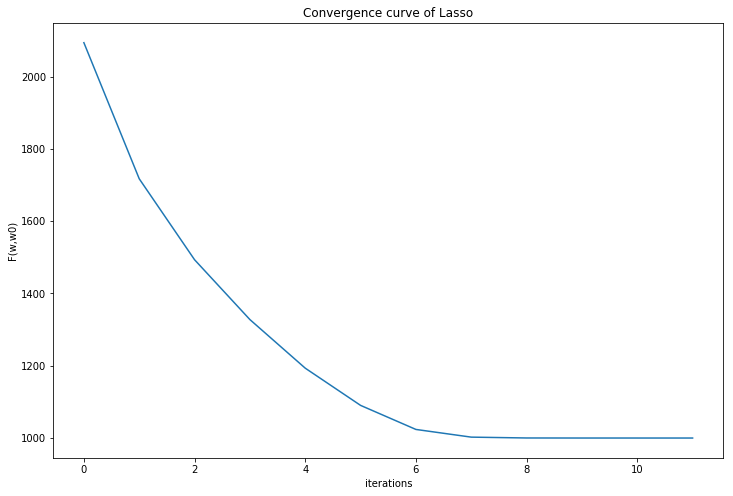

[ 9.61535331 -9.5288872  -9.53899489  9.58149795  9.73751133  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.15578917  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


In [11]:
# Problem 2.1: run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
wl, wl0 = lasso(X, y, lmda = 20.0, epsilon = 1.0e-3, draw_curve = True)
# have a look at the lasso model you got (sparse? where?)
print(wl)

In [12]:
# Problem 2.2
# TODO: evaluation function of lasso model
def Evaluate(X, y, w, w0, w_true, w0_true):

    # Evaluate lasso solution
    rmse = np.sqrt(1.0/X.shape[0])*np.linalg.norm(y - X.dot(w) - w0, 2)
    sparsity_w = np.count_nonzero(w)
    err_w = np.mean([np.mean(np.abs(w - w_true)), np.abs(w0 - w0_true)])
    overlap = np.sum(np.logical_and(w != 0,  w_true != 0))
    sumw = np.sum(w != 0)
    if sumw == 0:
        precision_w = 0
    else:
        precision_w = overlap/np.sum(w != 0)
    recall_w = overlap/np.sum(w_true != 0)
    
    return (rmse, err_w, sparsity_w, precision_w, recall_w)

In [13]:
# Problem 2.2
# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
Emetric = Evaluate(X, y, wl, wl0, w_true, w0_true)
print('RMSE =', float(Emetric[0]))
print('Err_w =', float(Emetric[1]))
print('Sparsity =', float(Emetric[2]))
print('Precision =', float(Emetric[3]))
print('Recall =', float(Emetric[4]))

RMSE = 1.2078556714009403
Err_w = 0.11151118339797995
Sparsity = 6.0
Precision = 0.8333333333333334
Recall = 1.0


In [19]:
# Problem 2.3
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPath(X, y, debias = False, num = 50, epsilon = 1.0e-2, max_iter = 100, lmda_min = 0.0):

    # Solution path of lasso
    lmda_max = np.max(np.abs(X.T.dot(y - np.mean(y))))
    lmda = np.linspace(lmda_max, lmda_min * lmda_max, num)
    W = np.array([])
    W0 = np.array([])
    n, d = X.shape
    start = time.time()
    w_init, w0_init = Initialw(X, y)
    print('initialize weight:', time.time()-start)
    
    start = time.time()
    is_sparse = sparse.issparse(X)
    if is_sparse:
        nX = X.multiply(X).sum(0).T
        Y = X.copy()
        cscMatInplaceEleMultEveryRow(Y, w_init)
        #Y = X.multiply(np.kron(w, np.ones(n).reshape(n,1))).tocsc()
    else:
        nX = np.sum(X*X, 0)
        Y = np.kron(w_init, np.ones(n).reshape(n,1)) * X
    print('Y initialize:', time.time() - start)

    # solve lasso for each lambda in lda
    for i in range(num):
        print('lasso path', i)
        w, w0 = lasso(X, y, lmda[i], epsilon, debias, max_iter, nX = nX.copy(), Y = Y.copy(), w = w_init.copy(), w0 = w0_init.copy())
        W = np.append(W, w)
        W0 = np.append(W0, w0)

    maxW = np.max(W[:])
    minW = np.min(W[:])
    W = W.reshape(num, d)
    
#     chose = np.logical_and(np.sum(W != 0, 1) >= 7, np.sum(np.abs(W),1) >= 25)
#     chose = lmda[chose]
#     chose = chose[0]

    plt.figure(figsize=(12, 8))
    for i in range(d):
        # plt.scatter(lda, W[:,i])
        plt.plot(lmda, W[:,i],'-')
#     plt.plot(chose*np.ones(100), np.linspace(minW-1, maxW+1, 100), '--k')
    # plt.gca().invert_xaxis()
    plt.ylabel('Coefficients')
    plt.xlabel('$\lambda$')
    plt.title('Solution Path of Lasso')
#     plt.annotate('$\lmda=$' + str(chose)[:6] + ' on $\hat w$', xy=(chose,maxW*0.8), xytext=(1.9*chose,0.8*maxW))
    plt.xlim([-1, lmda[0]])
    #plt.xscale('log')
    plt.ylim([minW,maxW])
    #plt.savefig('LassoPath.pdf', format='PDF')
    plt.show()

    W = W.T
    return (W, W0, lmda)

In [20]:
# Problem 2.3
# TODO: evaluate a given lasso solution path, draw plot of precision/recall vs. lmda
def EvaluatePath(X, y, W, W0, w_true, w0_true, lmda):

    num = np.size(W,1)
    Precision = np.zeros(num)
    Recall = np.zeros(num)
    RMSE = np.zeros(num)
    Err_w = np.zeros(num)
    Sparsity = np.zeros(num)

    for i in range(num):
        Emetric = Evaluate(X, y, W[:,i], W0[i], w_true, w0_true)
        RMSE[i] = float(Emetric[0]) 
        Err_w[i] = float(Emetric[1]) 
        Sparsity[i] = float(Emetric[2]) 
        Precision[i] = float(Emetric[3]) 
        Recall[i] = float(Emetric[4])

    plt.figure(figsize=(12, 8))
    idx = Precision <= 1
    plt.plot(lmda[idx], Precision[idx], '-sb')
    plt.plot(lmda, Recall, '-.r')
#     plt.plot(chose*np.ones(100), np.linspace(-0.2, 1.2, 100), '--k')
#     plt.annotate('Precision=' + str(float(Precision[lmda == chose]))[0:3] + ', Recall=' + str(float(Recall[lmda == chose]))[0:3] + ' on $\hat w$', xy=(chose,0.8), xytext=(2*chose,0.8))
    # plt.gca().invert_xaxis()
    plt.ylabel('Precision/Recall')
    plt.xlabel('$\lambda$')
    plt.title('Precision/Recall vs. $\lambda$ in Lasso')
    plt.grid(True)
    plt.xlim([0, lmda[0]])
    plt.ylim([-0.1,1.1])
    plt.legend(['Precision', 'Recall'], loc='upper left')
    # plt.savefig('PathPR.pdf', format='PDF')
    plt.show()

    return (RMSE, Err_w, Sparsity, Precision, Recall)

initialize weight: 0.0009617805480957031
Y initialize: 0.0011219978332519531
lasso path 0
stopped at iteration  1
lasso path 1
stopped at iteration  2
lasso path 2
stopped at iteration  3
lasso path 3
stopped at iteration  3
lasso path 4
stopped at iteration  3
lasso path 5
stopped at iteration  3
lasso path 6
stopped at iteration  3
lasso path 7
stopped at iteration  3
lasso path 8
stopped at iteration  4
lasso path 9
stopped at iteration  3
lasso path 10
stopped at iteration  3
lasso path 11
stopped at iteration  3
lasso path 12
stopped at iteration  5
lasso path 13
stopped at iteration  5
lasso path 14
stopped at iteration  5
lasso path 15
stopped at iteration  5
lasso path 16
stopped at iteration  5
lasso path 17
stopped at iteration  4
lasso path 18
stopped at iteration  4
lasso path 19
stopped at iteration  4
lasso path 20
stopped at iteration  4
lasso path 21
stopped at iteration  4
lasso path 22
stopped at iteration  5
lasso path 23
stopped at iteration  5
lasso path 24
stopped

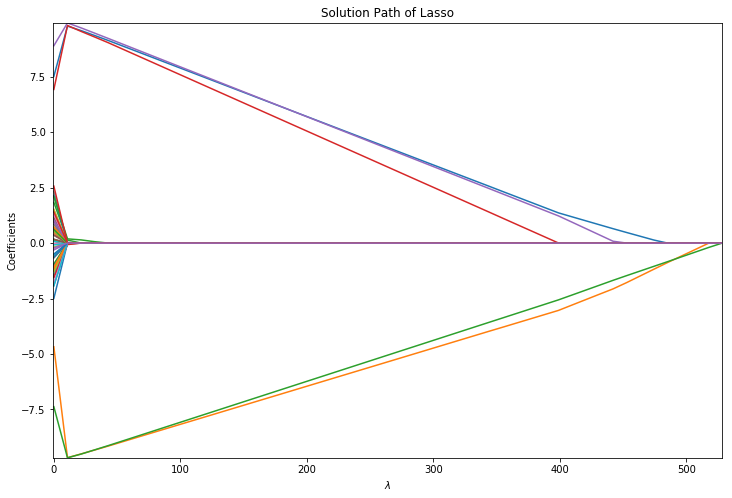

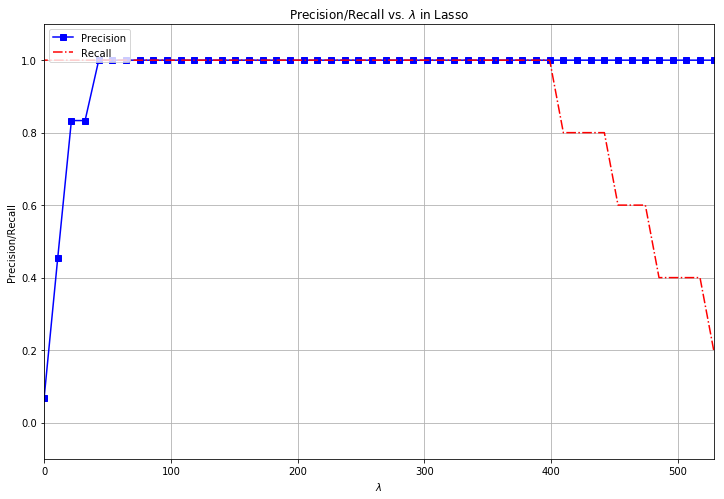

In [21]:
# Problem 2.3
# TODO: draw lasso solution path and precision/recall vs. lmda curves
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
LPath = LassoPath(X, y)
W = np.array(LPath[0])
W0 = np.array(LPath[1])
lmda = np.array(LPath[2])
EMetric = EvaluatePath(X, y, W, W0, w_true, w0_true, lmda)

initialize weight: 0.0006220340728759766
Y initialize: 0.0011777877807617188
lasso path 0
stopped at iteration  1
lasso path 1
stopped at iteration  3
lasso path 2
stopped at iteration  4
lasso path 3
stopped at iteration  4
lasso path 4
stopped at iteration  4
lasso path 5
stopped at iteration  4
lasso path 6
stopped at iteration  4
lasso path 7
stopped at iteration  5
lasso path 8
stopped at iteration  4
lasso path 9
stopped at iteration  4
lasso path 10
stopped at iteration  4
lasso path 11
stopped at iteration  4
lasso path 12
stopped at iteration  4
lasso path 13
stopped at iteration  5
lasso path 14
stopped at iteration  5
lasso path 15
stopped at iteration  5
lasso path 16
stopped at iteration  5
lasso path 17
stopped at iteration  5
lasso path 18
stopped at iteration  5
lasso path 19
stopped at iteration  5
lasso path 20
stopped at iteration  5
lasso path 21
stopped at iteration  5
lasso path 22
stopped at iteration  5
lasso path 23
stopped at iteration  5
lasso path 24
stopped

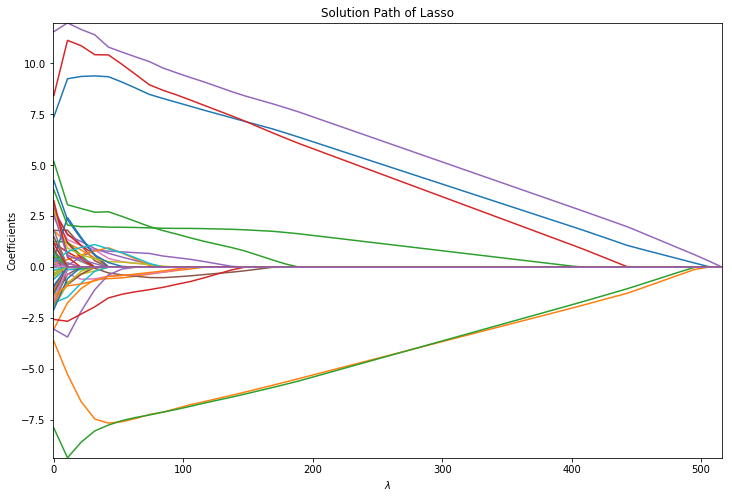

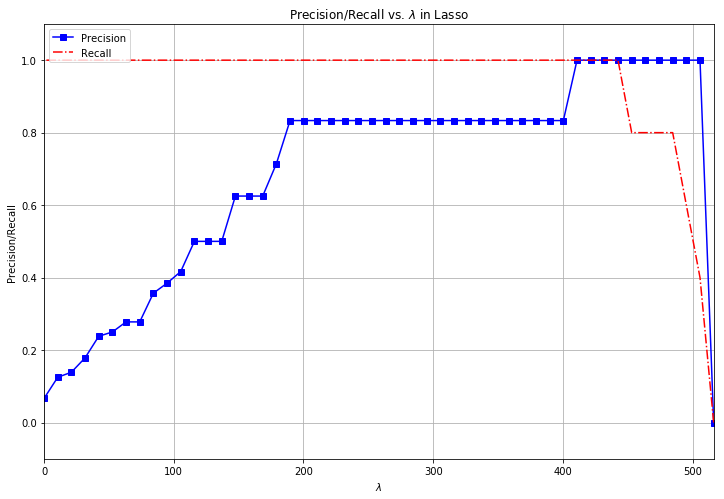

In [22]:
# Problem 2.3
# TODO: try a larger std sigma = 10.0
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)
LPath = LassoPath(X, y)
W = np.array(LPath[0])
W0 = np.array(LPath[1])
lmda = np.array(LPath[2])
EMetric = EvaluatePath(X, y, W, W0, w_true, w0_true, lmda)

initialize weight: 0.007834911346435547
Y initialize: 0.0011470317840576172
lasso path 0
stopped at iteration  1
lasso path 1
stopped at iteration  2
lasso path 2
stopped at iteration  2
lasso path 3
stopped at iteration  2
lasso path 4
stopped at iteration  2
lasso path 5
stopped at iteration  2
lasso path 6
stopped at iteration  2
lasso path 7
stopped at iteration  2
lasso path 8
stopped at iteration  2
lasso path 9
stopped at iteration  2
lasso path 10
stopped at iteration  2
lasso path 11
stopped at iteration  2
lasso path 12
stopped at iteration  2
lasso path 13
stopped at iteration  2
lasso path 14
stopped at iteration  2
lasso path 15
stopped at iteration  2
lasso path 16
stopped at iteration  2
lasso path 17
stopped at iteration  2
lasso path 18
stopped at iteration  2
lasso path 19
stopped at iteration  3
lasso path 20
stopped at iteration  3
lasso path 21
stopped at iteration  4
lasso path 22
stopped at iteration  4
lasso path 23
stopped at iteration  4
lasso path 24
stopped 

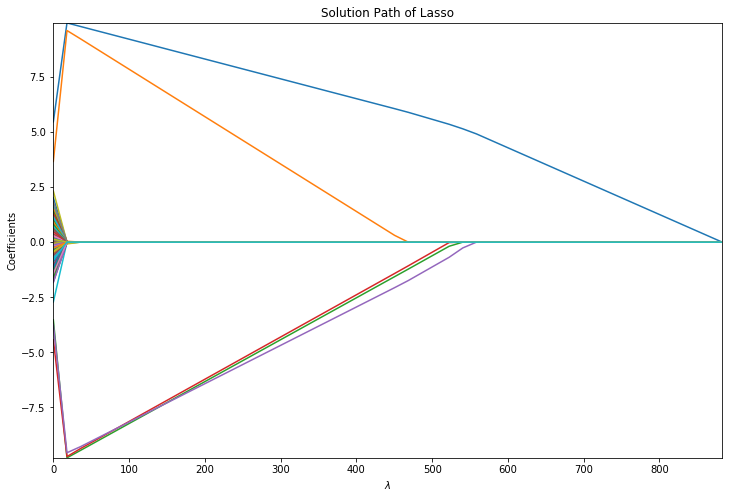

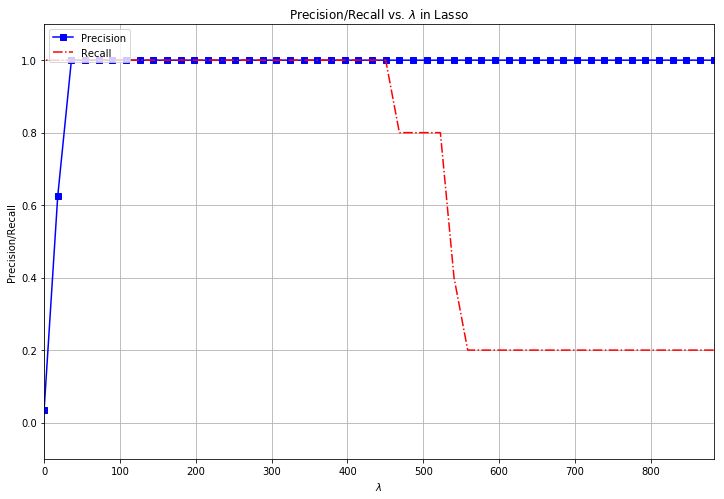

In [23]:
# Problem 2.4
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=50, d=150, k=5, sigma=1.0)
LPath = LassoPath(X, y)
W = np.array(LPath[0])
W0 = np.array(LPath[1])
lmda = np.array(LPath[2])
EMetric = EvaluatePath(X, y, W, W0, w_true, w0_true, lmda)

initialize weight: 0.05972123146057129
Y initialize: 0.001699686050415039
lasso path 0
stopped at iteration  1
lasso path 1
stopped at iteration  2
lasso path 2
stopped at iteration  2
lasso path 3
stopped at iteration  2
lasso path 4
stopped at iteration  2
lasso path 5
stopped at iteration  2
lasso path 6
stopped at iteration  2
lasso path 7
stopped at iteration  2
lasso path 8
stopped at iteration  2
lasso path 9
stopped at iteration  2
lasso path 10
stopped at iteration  2
lasso path 11
stopped at iteration  2
lasso path 12
stopped at iteration  2
lasso path 13
stopped at iteration  2
lasso path 14
stopped at iteration  2
lasso path 15
stopped at iteration  2
lasso path 16
stopped at iteration  3
lasso path 17
stopped at iteration  3
lasso path 18
stopped at iteration  3
lasso path 19
stopped at iteration  4
lasso path 20
stopped at iteration  3
lasso path 21
stopped at iteration  3
lasso path 22
stopped at iteration  4
lasso path 23
stopped at iteration  4
lasso path 24
stopped at

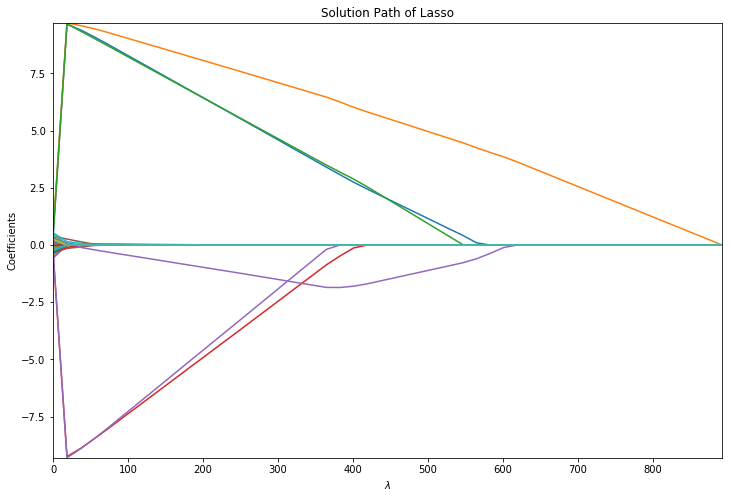

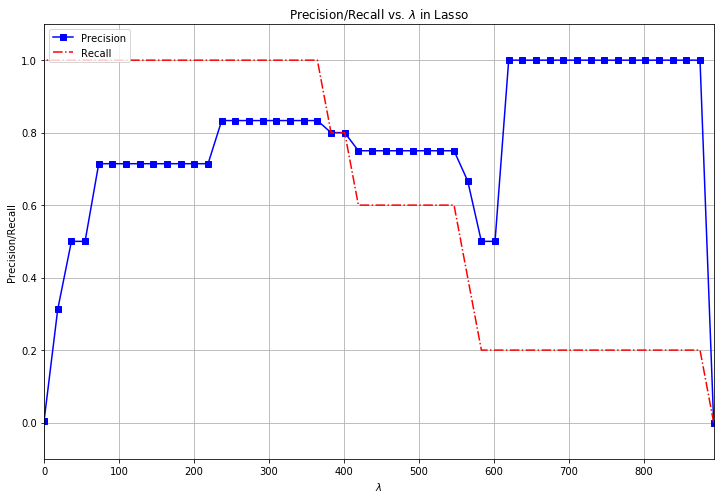

In [24]:
X, y, w_true, w0_true = DataGenerator(n=50, d=1000, k=5, sigma=1.0)
LPath = LassoPath(X, y)
W = np.array(LPath[0])
W0 = np.array(LPath[1])
lmda = np.array(LPath[2])
EMetric = EvaluatePath(X, y, W, W0, w_true, w0_true, lmda)

/Users/tianyizhou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


initialize weight: 0.00983428955078125
Y initialize: 0.0008778572082519531
lasso path 0
stopped at iteration  1
lasso path 1
stopped at iteration  2
lasso path 2
stopped at iteration  2
lasso path 3
stopped at iteration  2
lasso path 4
stopped at iteration  2
lasso path 5
stopped at iteration  2
lasso path 6
stopped at iteration  3
lasso path 7
stopped at iteration  3
lasso path 8
stopped at iteration  3
lasso path 9
stopped at iteration  3
lasso path 10
stopped at iteration  3
lasso path 11
stopped at iteration  3
lasso path 12
stopped at iteration  3
lasso path 13
stopped at iteration  3
lasso path 14
stopped at iteration  3
lasso path 15
stopped at iteration  3
lasso path 16
stopped at iteration  3
lasso path 17
stopped at iteration  3
lasso path 18
stopped at iteration  4
lasso path 19
stopped at iteration  4
lasso path 20
stopped at iteration  4
lasso path 21
stopped at iteration  4
lasso path 22
stopped at iteration  4
lasso path 23
stopped at iteration  4
lasso path 24
stopped a

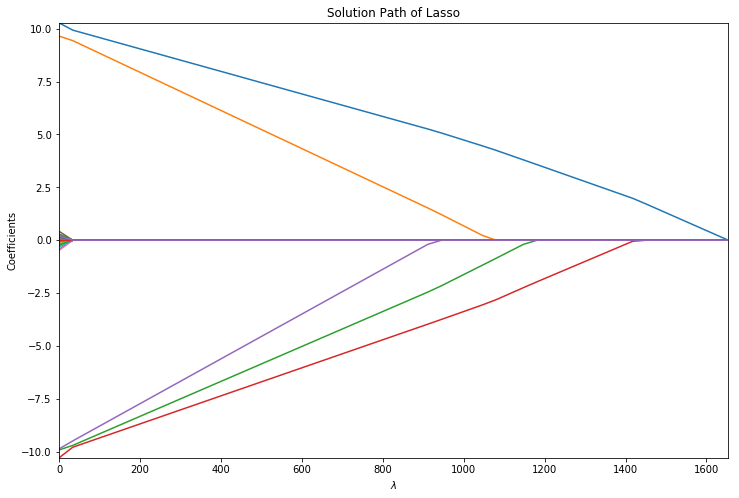

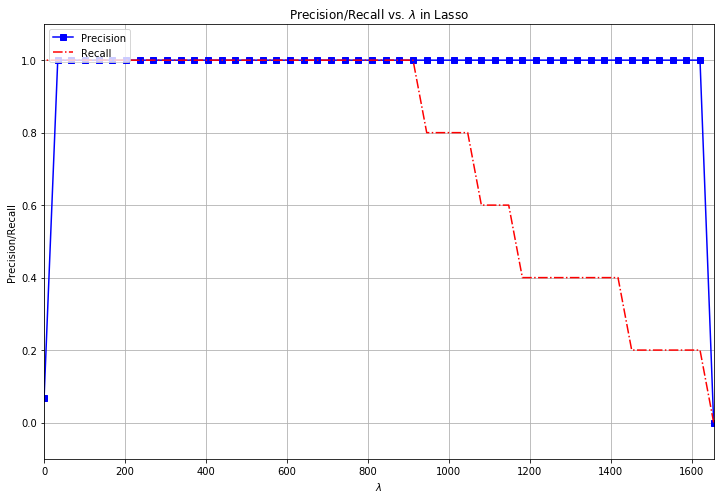

In [25]:
X, y, w_true, w0_true = DataGenerator(n=100, d=75, k=5, sigma=1.0)
LPath = LassoPath(X, y)
W = np.array(LPath[0])
W0 = np.array(LPath[1])
lmda = np.array(LPath[2])
EMetric = EvaluatePath(X, y, W, W0, w_true, w0_true, lmda)

initialize weight: 0.0006830692291259766
Y initialize: 0.0010559558868408203
lasso path 0
stopped at iteration  1
lasso path 1
stopped at iteration  2
lasso path 2
stopped at iteration  2
lasso path 3
stopped at iteration  2
lasso path 4
stopped at iteration  2
lasso path 5
stopped at iteration  2
lasso path 6
stopped at iteration  2
lasso path 7
stopped at iteration  2
lasso path 8
stopped at iteration  3
lasso path 9
stopped at iteration  3
lasso path 10
stopped at iteration  3
lasso path 11
stopped at iteration  3
lasso path 12
stopped at iteration  3
lasso path 13
stopped at iteration  3
lasso path 14
stopped at iteration  3
lasso path 15
stopped at iteration  3
lasso path 16
stopped at iteration  4
lasso path 17
stopped at iteration  4
lasso path 18
stopped at iteration  4
lasso path 19
stopped at iteration  4
lasso path 20
stopped at iteration  4
lasso path 21
stopped at iteration  4
lasso path 22
stopped at iteration  4
lasso path 23
stopped at iteration  4
lasso path 24
stopped

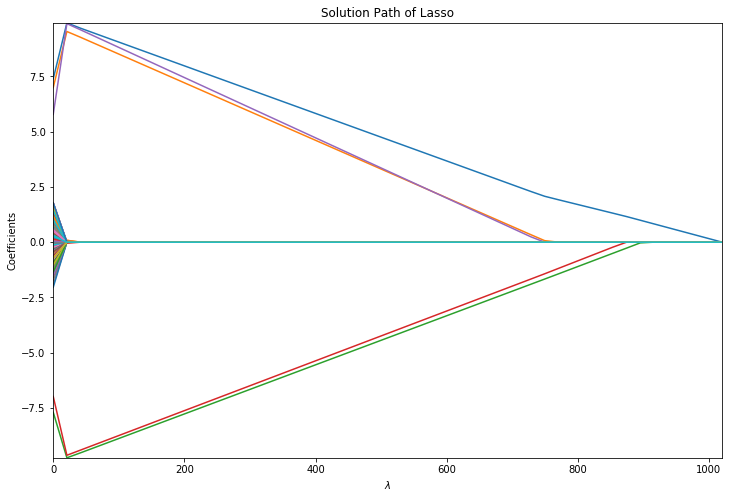

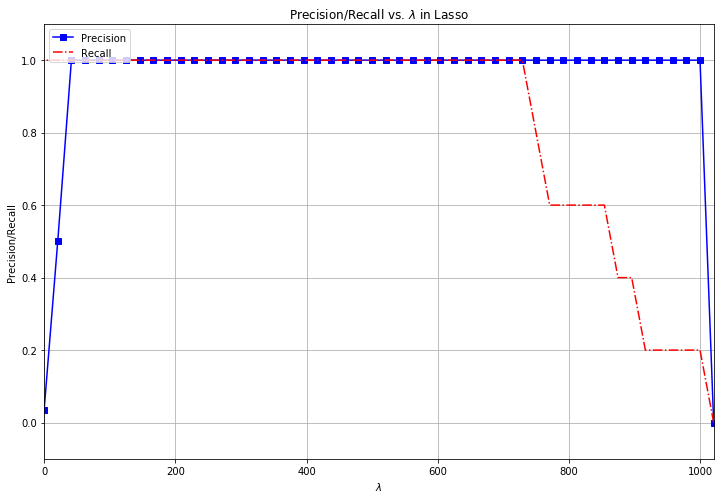

In [26]:
X, y, w_true, w0_true = DataGenerator(n=100, d=150, k=5, sigma=1.0)
LPath = LassoPath(X, y)
W = np.array(LPath[0])
W0 = np.array(LPath[1])
lmda = np.array(LPath[2])
EMetric = EvaluatePath(X, y, W, W0, w_true, w0_true, lmda)

initialize weight: 0.054575204849243164
Y initialize: 0.0021953582763671875
lasso path 0
stopped at iteration  1
lasso path 1
stopped at iteration  2
lasso path 2
stopped at iteration  2
lasso path 3
stopped at iteration  2
lasso path 4
stopped at iteration  2
lasso path 5
stopped at iteration  3
lasso path 6
stopped at iteration  3
lasso path 7
stopped at iteration  3
lasso path 8
stopped at iteration  3
lasso path 9
stopped at iteration  3
lasso path 10
stopped at iteration  3
lasso path 11
stopped at iteration  3
lasso path 12
stopped at iteration  3
lasso path 13
stopped at iteration  3
lasso path 14
stopped at iteration  4
lasso path 15
stopped at iteration  4
lasso path 16
stopped at iteration  4
lasso path 17
stopped at iteration  4
lasso path 18
stopped at iteration  4
lasso path 19
stopped at iteration  4
lasso path 20
stopped at iteration  4
lasso path 21
stopped at iteration  4
lasso path 22
stopped at iteration  4
lasso path 23
stopped at iteration  4
lasso path 24
stopped 

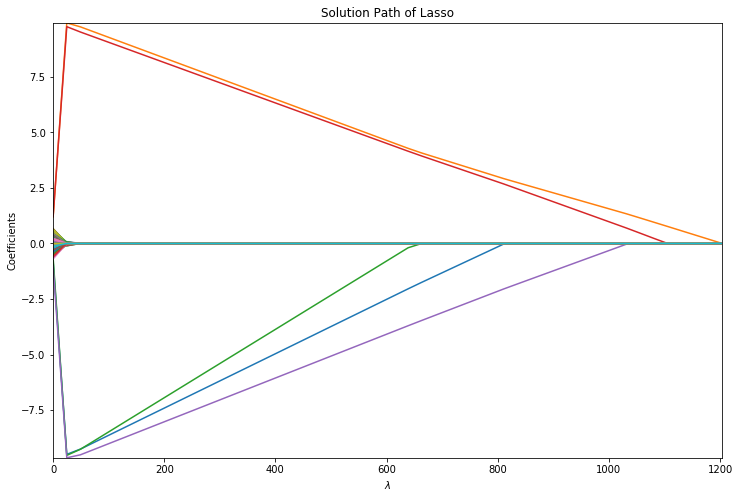

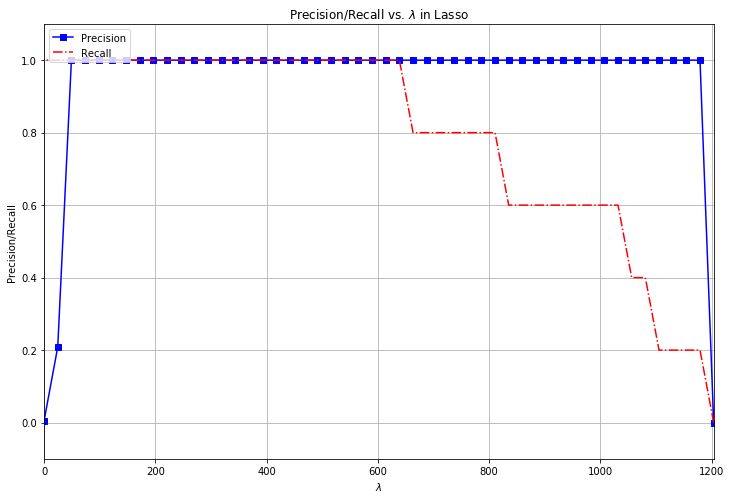

In [27]:
X, y, w_true, w0_true = DataGenerator(n=100, d=1000, k=5, sigma=1.0)
LPath = LassoPath(X, y)
W = np.array(LPath[0])
W0 = np.array(LPath[1])
lmda = np.array(LPath[2])
EMetric = EvaluatePath(X, y, W, W0, w_true, w0_true, lmda)

In [28]:
# Problem 2.5: predict reviews' star on Yelp
# GIVEN: data parser for reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=np.int)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")
    print('X shape', X.shape)

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)

In [30]:
# Problem 2.5: predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots
def Validation(X_train, y_train, X_valid, y_valid):

    # Lasso solutions for different lambda on training set
    LPath = LassoPath(X_train, y_train, num = 20, lmda_min = 0.1)
    W = np.array(LPath[0])
    W0 = np.array(LPath[1])
    lmda = np.array(LPath[2])
    num = len(lmda)
    RMSE_train = np.zeros(num)
    RMSE_valid = np.zeros(num)
    Sparsity = np.zeros(num)

    # evaluate each solution on validation set
    for i in range(num):
        Emetric = Evaluate(X_train, y_train, W[:,i], W0[i], W[:,i], W0[i])
        RMSE_train[i] = float(Emetric[0])
        Sparsity[i] = float(Emetric[2])
        Emetric = Evaluate(X_valid, y_valid, W[:,i], W0[i], W[:,i], W0[i])
        RMSE_valid[i] = float(Emetric[0])

    # select the solution with smallest RMSE on validation set
    chose = RMSE_valid.argmin()
    w_lasso = W[:,chose]
    w0_lasso = W0[chose]
    lmda_lasso = lmda[chose]
    Rmax = np.max([np.max(RMSE_train),np.max(RMSE_valid)])
    Rmin = np.min([np.min(RMSE_train),np.min(RMSE_valid)])

    # RMSE vs. lambda plot 
    plt.figure(figsize=(12, 8))
    plt.plot(lmda, RMSE_train, '-sb')
    plt.plot(lmda, RMSE_valid, '-or')
    plt.plot(lmda[chose]*np.ones(100), np.linspace(Rmin-0.1, Rmax+0.1, 100), '--k')
    plt.annotate('Train. RMSE =' + str(float(RMSE_train[chose]))[0:3] + ', Valid. RMSE=' + str(float(RMSE_valid[chose]))[0:3] + ' on $\hat w$', xy=(lmda[chose],0.95*Rmax), xytext=(35+lmda[chose],0.95*Rmax))
    # plt.gca().invert_xaxis()
    plt.ylabel('RMSE')
    plt.xlabel('$\lambda$')
    plt.title('RMSE vs. $\lambda$ on Training and Validation sets')
    plt.grid(True)
    plt.xlim([0, lmda[0]])
    plt.ylim([Rmin-0.1,Rmax+0.1])
    plt.legend(['RMSE on Training set', 'RMSE on Validation set'], loc='upper left')
    #plt.savefig('RMSE.pdf', format='PDF')
    plt.show()

    # Sparsity vs. lambda plot
    plt.figure(figsize=(12, 8))
    plt.plot(lmda, Sparsity, '-or')
    plt.plot(lmda[chose]*np.ones(100), np.linspace(0, len(w_lasso), 100), '--k')
    plt.annotate('No. of nonzeros =' + str(int(Sparsity[chose]))[0:4] + ' in $\hat w$', xy=(lmda[chose],0.8*len(w_lasso)), xytext=(30+lmda[chose],0.8*len(w_lasso)))
    #plt.gca().invert_xaxis()
    plt.ylabel('Sparsity (number of nonzeros)')
    plt.xlabel('$\lambda$')
    plt.title('Sparsity vs. $\lambda$ for Lasso')
    plt.grid(True)
    plt.xlim([0, lmda[0]])
    #plt.savefig('Sparsity.pdf', format='PDF')
    plt.show()

    return (w_lasso, w0_lasso, lmda[chose])

/Users/tianyizhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


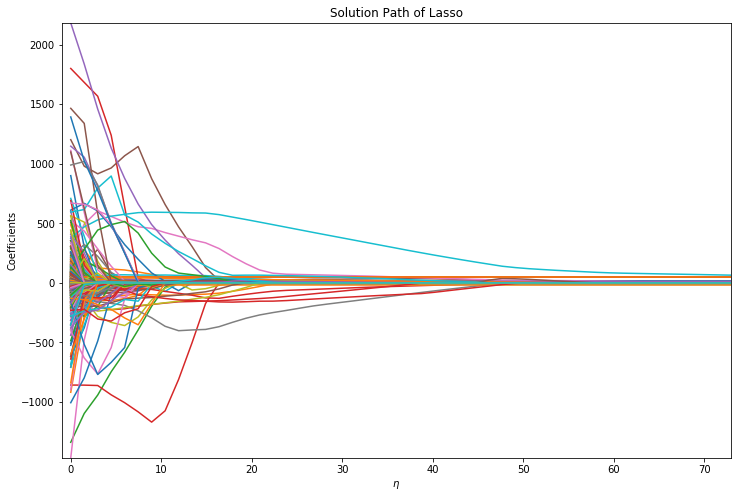

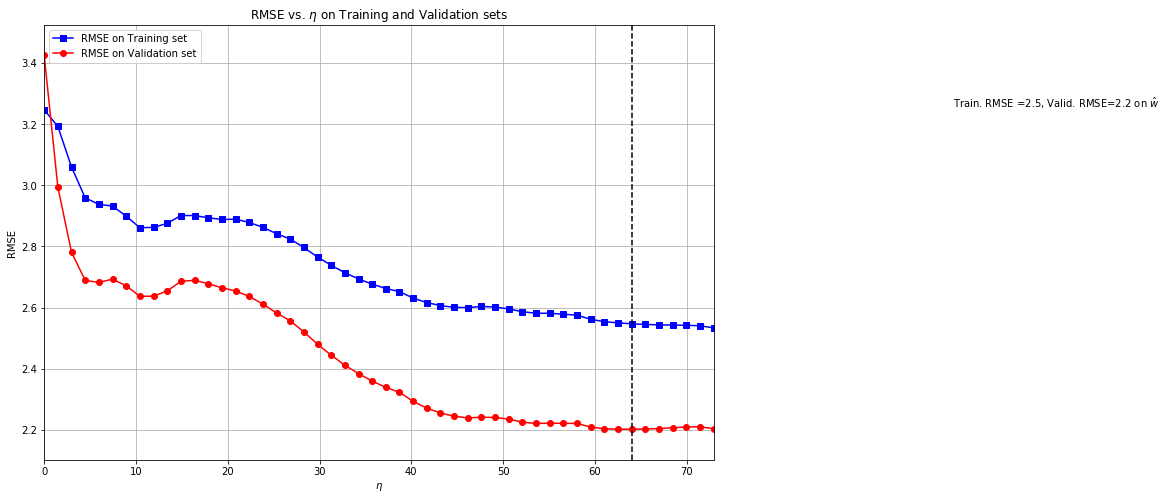

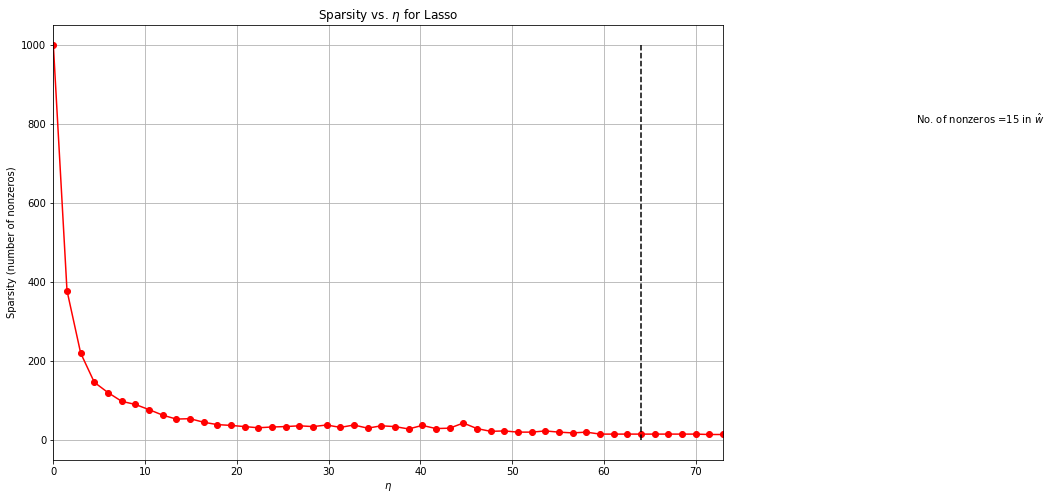

Lasso select features:
log(ReviewNumCharacters*BusinessNumReviews) 77.39441669357994
indicator(ReviewNumCharacters) 47.05965197281227
indicator(ReviewNumCharacters*BusinessLongitude) 47.05965197248426
indicator(ReviewNumWords*BusinessNumReviews) 47.05965197248053
indicator(ReviewNumCharacters*UserAverageStars) -19.732097407382525
indicator(UserAverageStars*BusinessNumStars) 18.501617620851
log(ReviewDate*ReviewNumWords) 17.406469093218007
sq(ReviewDate*BusinessLatitude) -13.500186218837365
sqrt(BusinessLongitude*BusinessLatitude) 13.16478826780315
log(UserUsefulVotes) 8.80553655916642
upvote: $\eta$ = 64.0287312881181
upvote: RMSE on test set = 2.696383387066027


In [320]:
X, y, X_valid, y_valid, X_test, y_test, fName = DataParser('../data/upvote_data.csv', '../data/upvote_labels.txt', '../data/upvote_features.txt', 4000, 1000)

UV = Validation(X, y, X_valid, y_valid)
w_upvote = np.array(UV[0])
w0_upvote = np.array(UV[1])
lmda_upvote = np.array(UV[2])
Emetric_upvote = Evaluate(X_test, y_test, w_upvote, w0_upvote, w_upvote, w0_upvote)
RMSE_test_upvote = float(Emetric_upvote[0])

idx = (-np.abs(w_upvote)).argsort()[0:10]
print('Lasso select features:')
for i in range(10):
    print(fName[idx[i]],w_upvote[idx[i]])
print('upvote: lambda =', lmda_upvote)
print('upvote: RMSE on test set =', RMSE_test_upvote)

X shape (45000, 2500)
initialize weight: 7.36297869682312
Y initialize: 0.02086186408996582
lasso path 0
stopped at iteration  13
lasso path 1
stopped at iteration  13
lasso path 2
stopped at iteration  14
lasso path 3
stopped at iteration  14
lasso path 4
stopped at iteration  16
lasso path 5
stopped at iteration  17
lasso path 6
stopped at iteration  18
lasso path 7
stopped at iteration  19
lasso path 8
stopped at iteration  21
lasso path 9
stopped at iteration  33
lasso path 10
stopped at iteration  34
lasso path 11
stopped at iteration  35
lasso path 12
stopped at iteration  37
lasso path 13
stopped at iteration  40
lasso path 14
stopped at iteration  42
lasso path 15
stopped at iteration  44
lasso path 16
stopped at iteration  52
lasso path 17
stopped at iteration  63
lasso path 18
stopped at iteration  84
lasso path 19
stopped at iteration  99


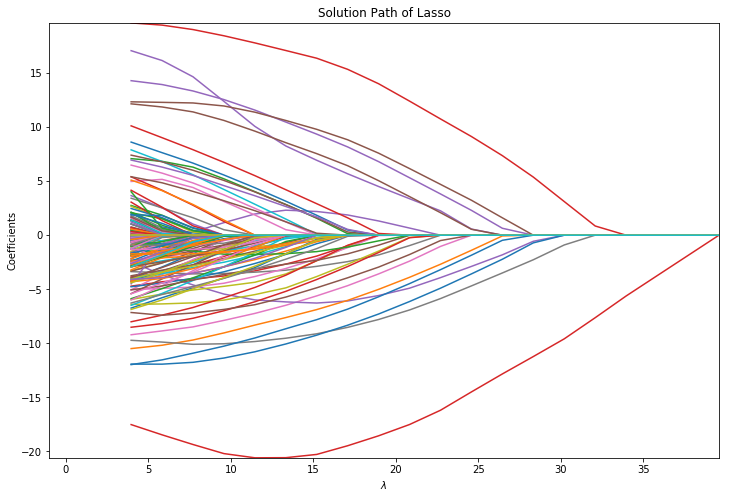

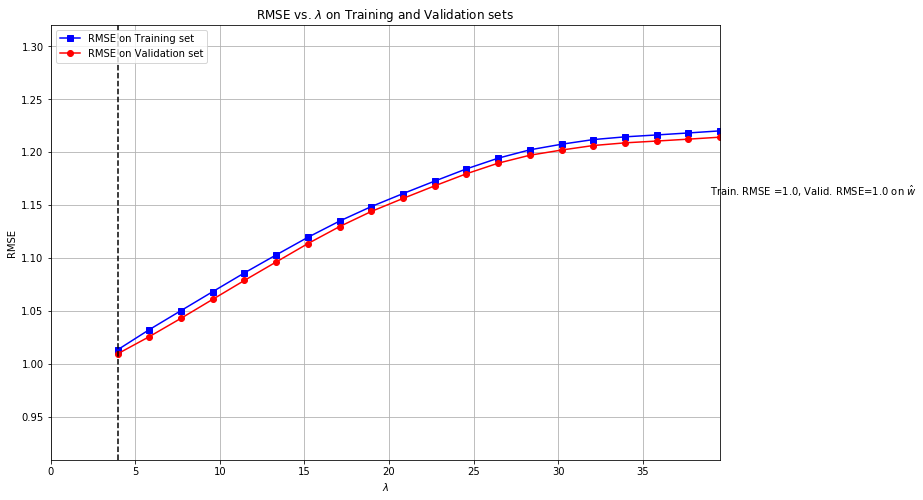

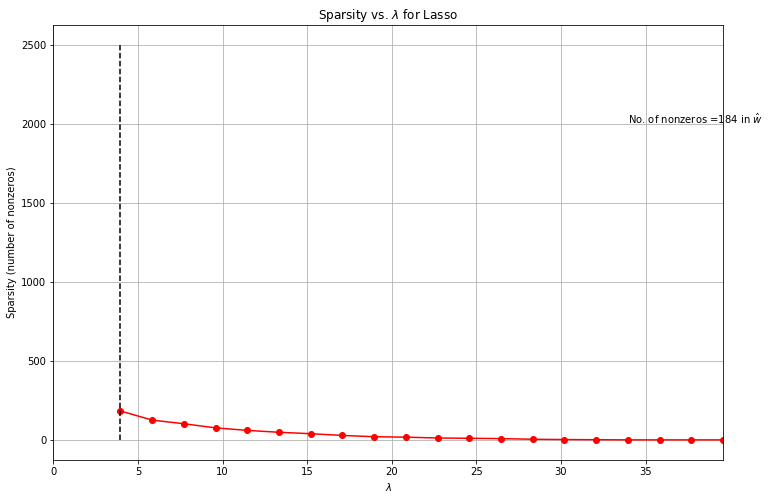

lasso path time = 5849.506194114685
Lasso select features:
great 19.641067590424402
not -17.52587114361591
best 17.07200091121539
amazing 14.296104321816303
love 12.340775728025795
delicious 12.153509845597274
rude -11.976917933050283
the worst -11.928364504812563
horrible -10.49274470263451
awesome 10.117109137396158
star: lambda = 3.957825401364829
star: RMSE on test set = 1.0251847645955723


In [31]:
# Problem 2.5: predict reviews' star on Yelp
# TODO: evaluation of your results

# load Yelp data: change the address of data files on your own machine if necessary
from scipy.sparse.linalg import lsqr
add = '../data/'
X, y, X_valid, y_valid, X_test, y_test, fName = DataParser(add+'star_data.mtx', add+'star_labels.txt', add+'star_features.txt', 30000, 5000)

# evaluation
start = time.time()
UV = Validation(X, y, X_valid, y_valid)
print('lasso path time =', time.time() - start)
w_star = np.array(UV[0])
w0_star = np.array(UV[1])
lmda_star = np.array(UV[2])
Emetric_star = Evaluate(X_test, y_test, w_star, w0_star, w_star, w0_star)
RMSE_test_star = float(Emetric_star[0])

# print the top-10 features you found by lasso
idx = (-np.abs(w_star)).argsort()[0:10]
print('Lasso select features:')
for i in range(10):
    print(fName[idx[i]],w_star[idx[i]])
print('star: lambda =', lmda_star)
print('star: RMSE on test set =', RMSE_test_star)